## Model Validation

In [1]:
import pandas as pd
import numpy as np
import random
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
from sklearn.model_selection import train_test_split
from models.lds_utils import get_lds_kernel_window
from models.loss import *
from models.sfcn_fds import *
from collections import Counter
from scipy.ndimage import zoom, convolve1d
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [2]:
def load_data(img_dir, label_dir, label_name, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
        self.bin_edges = np.histogram_bin_edges(self.y, bins='auto')
        self.weights = self._prepare_weights(lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transform is not None:
            image = self.transform(image)
        label = np.array([self.y[idx]]).astype('float16')
        weight = np.array([self.weights[idx]]).astype('float16') if self.weights is not None else np.asarray([np.float16(1.)])
        return [image, label, weight]
    
    def _prepare_weights(self, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):  
        weights = None
        if lds:
            labels = self.y
            bin_index_per_label = [self._get_bin_idx(label) for label in labels]
            Nb = max(bin_index_per_label) + 1
            num_samples_of_bins = dict(Counter(bin_index_per_label))
            emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

            lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
            eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

            eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
            weights = np.array([np.float32(1 / x) for x in eff_num_per_label]).reshape(labels.shape)
        return weights
    
    def _get_bin_idx(self, label):
        return np.max(np.where(self.bin_edges <= label))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
device_count = torch.cuda.device_count()
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [7]:
label_name = 'FL_WMH_VOL_icv'
# label_name = 'FL_WMH_VOL_mL'
# label_name = 'WMH_GRADE'
# label_name = 'Cortical Gray Matter Total Percent Of Icv'
# label_name = 'FL_PVWMH_VOL_icv'
# label_name = 'FL_DWMH_VOL_icv'
img_dir = 'img_npy/'
label_dir = 'labels/data_975.csv'

In [8]:
batch_size = 16
test_batch_size = 32

In [9]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=True, norm=True)

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train set
# train_set = NeckDataset(X_train, y_train)

# test set & loader
test_set = NeckDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=test_batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

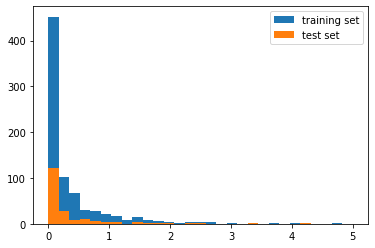

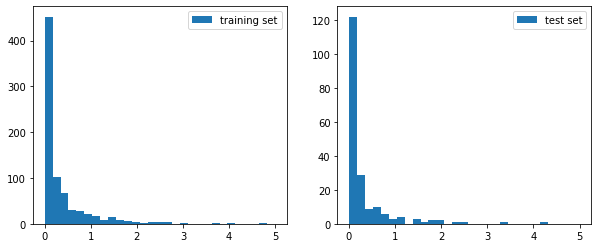

In [10]:
bins = np.linspace(0, 5, 30)

plt.hist(y_train, bins, label='training set')
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')
plt.show()
plt.close()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_train, bins, label='training set')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')

plt.show()
plt.close()

In [11]:
import seaborn as sns
from sklearn.metrics import r2_score
from torchmetrics import R2Score

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels, _ in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # Get Coefficient of Determination r^2
    r2 = r2_score(preds, truths)
    torch_r2 = R2Score()
    r2_2 = torch_r2(torch.tensor(preds), torch.tensor(truths))
    
    # Sum of square of Regression
    SSR = np.sum((preds - np.mean(truths))**2)
    # Sum of square of errors
    SSE = np.sum((truths - preds)**2)
    # Total sum of squares
    SST0 = SSR + SSE
    
    # For range setting (with margin)
    _min = y_min - 0.5
    _max = y_max + 0.5
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
#     label = 'Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f} / R2 = {:.2f} / Torch R2 = {:.2f} / SSR/SST0 = {:.2f} / 1-SSE/SST0 = {:.2f}'.format(pearson,spearman,r2,r2_2,SSR/SST0, 1-SSE/SST0)
#     plt.scatter(truths, preds, c='steelblue', label=label)
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

In [12]:
y_min, y_max =y_test.min(), y_test.max()
y_min, y_max

(0.0, 4.201782967868128)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


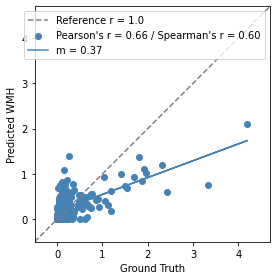

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.97it/s]


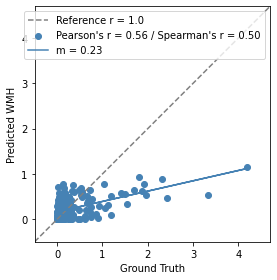

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.71it/s]


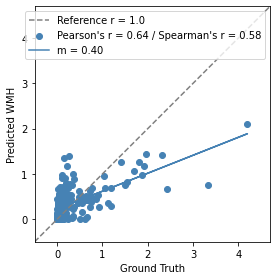

In [51]:
fds = True
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader, line=True)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader, line=True)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader, line=True)

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.30it/s]


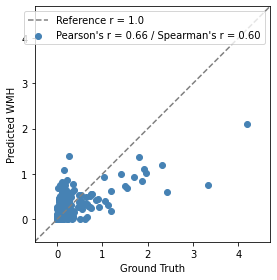

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]


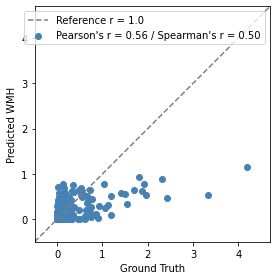

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.18it/s]


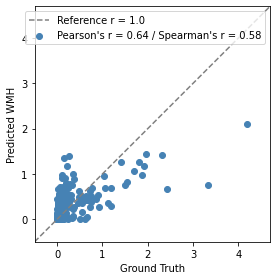

In [42]:
fds = True
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.70it/s]


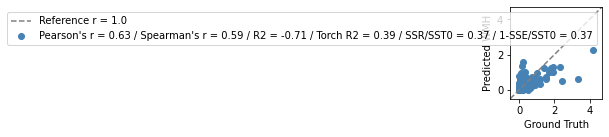

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.87it/s]


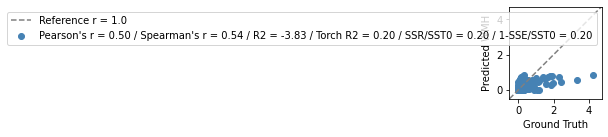

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.00it/s]


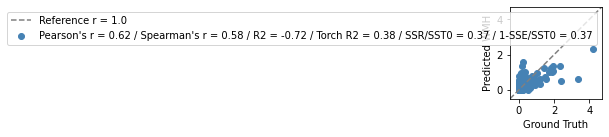

In [38]:
fds = True
weight_decay = 0.01
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.85it/s]


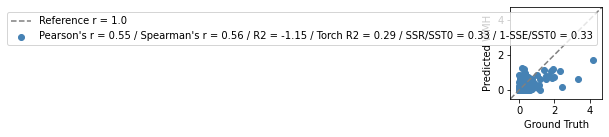

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.74it/s]


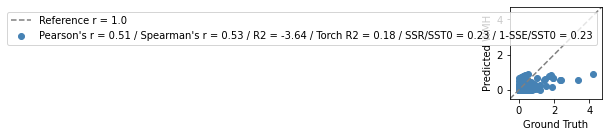

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.01it/s]


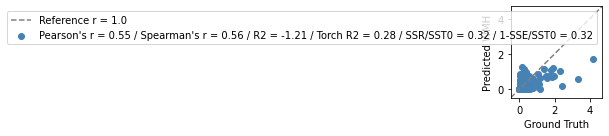

In [39]:
fds = True
weight_decay = 0.1
lr = 1e-04
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.86it/s]


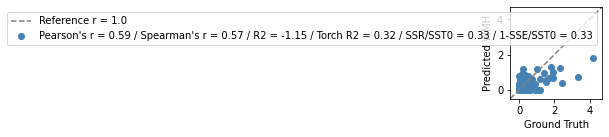

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.00it/s]


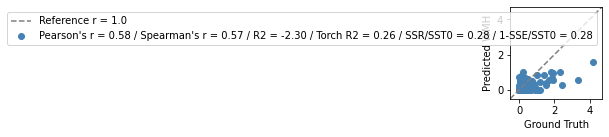

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.70it/s]


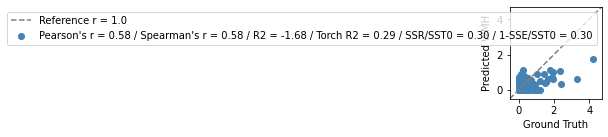

In [40]:
fds = True
weight_decay = 0.1
lr = 1e-05
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.03it/s]


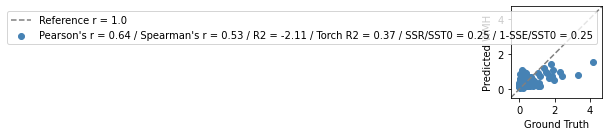

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.86it/s]


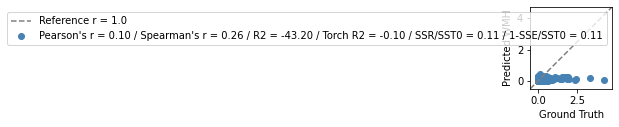

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.92it/s]


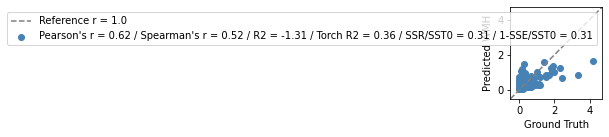

In [41]:
fds = True
weight_decay = 0.1
lr = 1e-03
optim_class = optim.Adam
sched_class = optim.lr_scheduler.ReduceLROnPlateau

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse+Adam_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse+Adam_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse+Adam_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.95it/s]


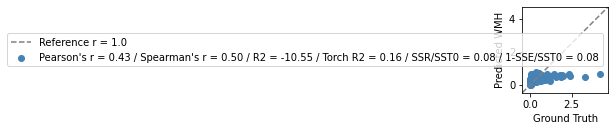

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.97it/s]


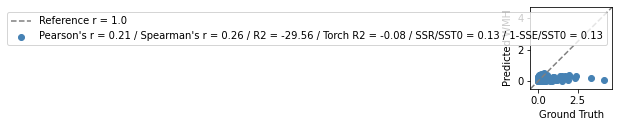

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.84it/s]


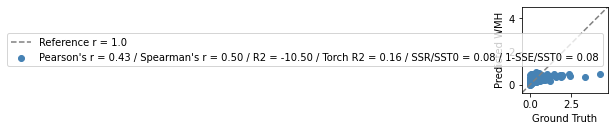

In [42]:
fds = True
weight_decay = 0.1
lr = 1e-03
optim_class = optim.SGD
sched_class = optim.lr_scheduler.ReduceLROnPlateau

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse+SGD_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse+SGD_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse+SGD_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.63it/s]


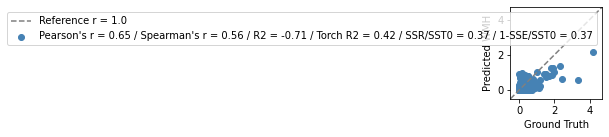

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.92it/s]


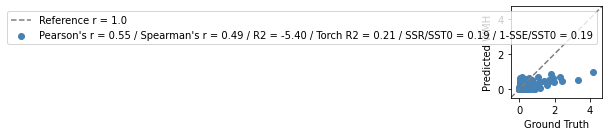

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.66it/s]


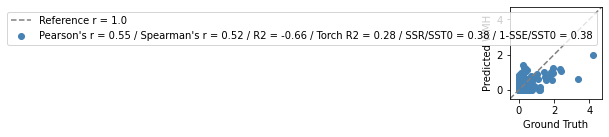

In [43]:
fds = True
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.CosineAnnealingWarmRestarts

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.61it/s]


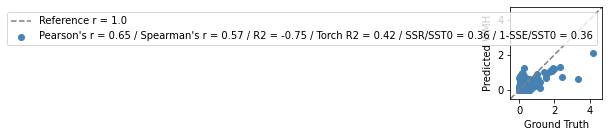

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.80it/s]


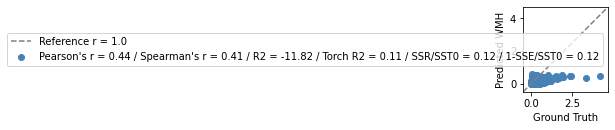

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.00it/s]


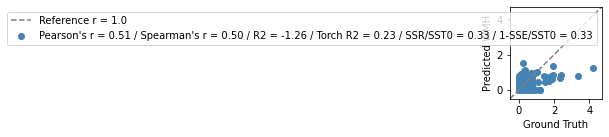

In [44]:
fds = True
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.CosineAnnealingLR

# best MSE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs150'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.76it/s]


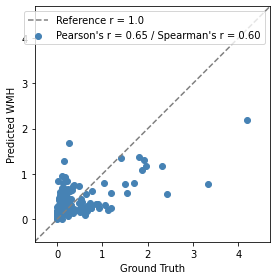

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.92it/s]


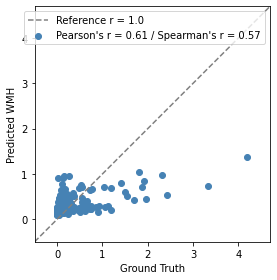

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.77it/s]


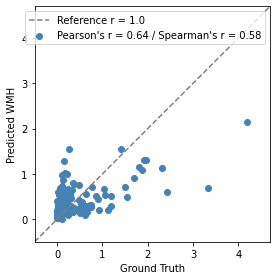

In [14]:
fds = True
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau
epochs = 150

# best MSE
net = SFCN_FDS(fds=fds)
net.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230308_sfcnfdsfc3.2+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230308_sfcnfdsfc3.2+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfdsfc3.2+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.19it/s]


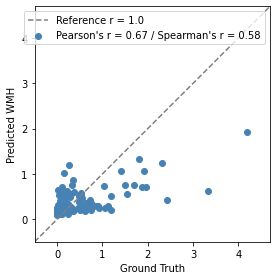

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]


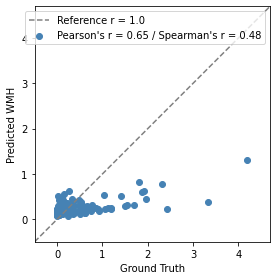

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


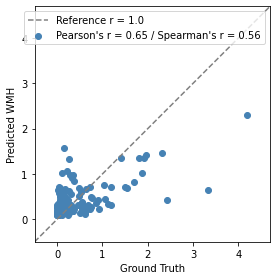

In [46]:
fds = True
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau
epochs = 150

# best MSE
net = SFCN_FDS(fds=fds)
net.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,8),
    nn.ReLU(),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230308_sfcnfdsfc4.2+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# best MAE
net = SFCN_FDS(fds=fds)
net.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,8),
    nn.ReLU(),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230308_sfcnfdsfc4.2+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr)))
net.cuda()
_,_ = predict(net, test_loader)

# epoch 150
net = SFCN_FDS(fds=fds)
net.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,8),
    nn.ReLU(),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230307_sfcnfdsfc4.2+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs)))
net.cuda()
_,_ = predict(net, test_loader)